In [1]:
import numpy as np
import matplotlib.pyplot as plt
from transforms3d.euler import mat2euler
from pr3_utils import *
from tqdm.notebook import tqdm
import scipy

# Initialisation

In [136]:
DATASET = "03"

In [137]:
# Load the measurements
filename = f'../data/{DATASET}.npz'
t,features,linear_velocity,angular_velocity,K,b,imu_T_cam = load_data(filename)
t = np.squeeze(t,0)

features = features[:,::2,:]


In [138]:
fsu = K[0,0]
fsv = K[1,1]
cu = K[0,2]
cv = K[1,2]
fsth = K[0,1]
print(f'fsu {fsu}\nfsv {fsv}\nfsth {fsth}\ncu {cu}\ncv {cv}')

fsu 552.554261
fsv 552.554261
fsth 0.0
cu 682.049453
cv 238.769549


In [139]:
Ks = np.array([[fsu,0,cu,0],
               [0,fsv,cv,0],
               [fsu,0,cu,-fsu*b],
               [0,fsv,cv,0]])
print(K)
print(Ks)

[[552.554261   0.       682.049453]
 [  0.       552.554261 238.769549]
 [  0.         0.         1.      ]]
[[ 552.554261     0.         682.049453     0.       ]
 [   0.         552.554261   238.769549     0.       ]
 [ 552.554261     0.         682.049453  -331.5325566]
 [   0.         552.554261   238.769549     0.       ]]


# Load Data

In [140]:
np.tile(t,(3,1)).shape

(3, 1010)

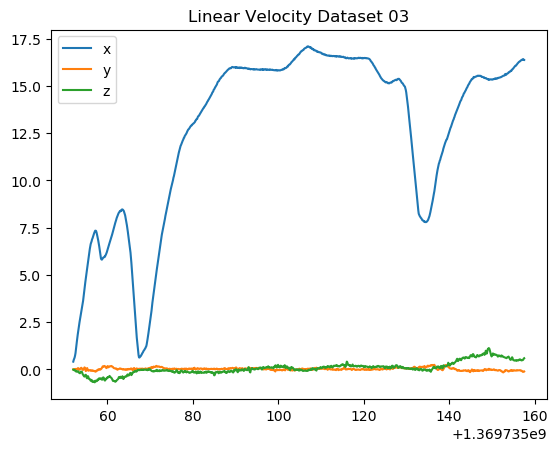

In [141]:
plt.plot(np.tile(t,(3,1)).T,linear_velocity.T)
plt.title(f'Linear Velocity Dataset {DATASET}')
plt.legend(['x','y','z'])

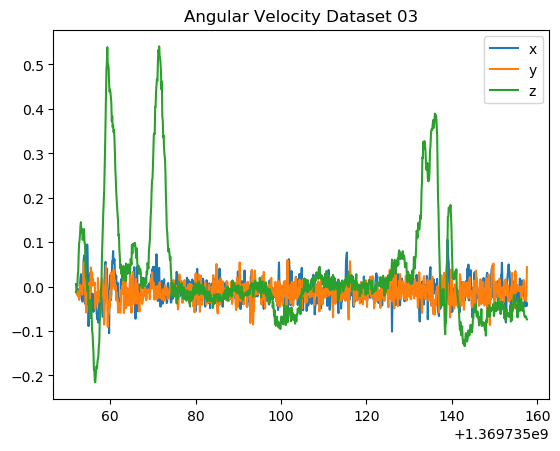

In [142]:
plt.plot(np.tile(t,(3,1)).T,angular_velocity.T)
plt.title(f'Angular Velocity Dataset {DATASET}')
plt.legend(['x','y','z'])

(-0.5, 1490.5, 600.5, -0.5)

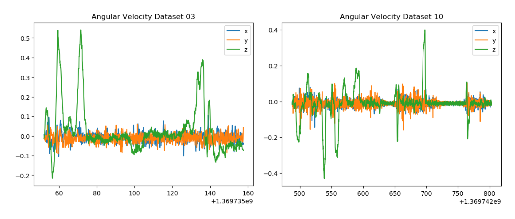

In [143]:
from PIL import Image
v3 = Image.open("/home/ashish/Desktop/UCSD Acads/Quarter 2/ECE276A/PR3/Images/03omega.png")
v10 = Image.open("/home/ashish/Desktop/UCSD Acads/Quarter 2/ECE276A/PR3/Images/10omega.png")
plt.imshow(np.hstack([v3,v10]))
plt.axis('off')

# Dead Reckoning

In [134]:
def visualize_trajectory_2d_own(pose,path_name="Unknown",show_ori=False,title="",scatterpts=None):
    '''
    function to visualize the trajectory in 2D
    Input:
        pose:   4*4*N matrix representing the camera pose, 
                where N is the number of poses, and each
                4*4 matrix is in SE(3)
    '''
    fig,ax = plt.subplots(figsize=(5,5))
    n_pose = pose.shape[2]
    ax.plot(pose[0,3,:],pose[1,3,:],'r-',label=path_name)
    ax.scatter(pose[0,3,0],pose[1,3,0],marker='s',label="start")
    ax.scatter(pose[0,3,-1],pose[1,3,-1],marker='o',label="end")
    if(not (scatterpts is None)):
        
  
    if show_ori:
        select_ori_index = list(range(0,n_pose,max(int(n_pose/50), 1)))
        yaw_list = []
        
        for i in select_ori_index:
            _,_,yaw = mat2euler(pose[:3,:3,i])
            yaw_list.append(yaw)
    
        dx = np.cos(yaw_list)
        dy = np.sin(yaw_list)
        dx,dy = [dx,dy]/np.sqrt(dx**2+dy**2)
        ax.quiver(pose[0,3,select_ori_index],pose[1,3,select_ori_index],dx,dy,\
            color="b",units="xy",width=1)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')
    ax.set_title(title)
    ax.grid(False)
    ax.legend()
    plt.show(block=True)

    return fig, ax



IndentationError: expected an indented block (4262084895.py, line 17)

In [43]:
INIT_T = np.eye(4)
INIT_SIGMA = np.eye(6)


In [44]:
dts = t[1:]-t[:-1]
meu = INIT_T;
meus = [meu]
axangles = np.vstack((linear_velocity,angular_velocity)).T
adtwists = axangle2adtwist(axangles)
twists = axangle2twist(axangles)
meu_updates = twist2pose(twists[1:]*np.expand_dims(np.expand_dims(dts,-1),-1))
for i,dt in enumerate(tqdm(dts)):
    meu = meu @ meu_updates[i]
    meus+=[meu]
meus = np.array(meus)
    
    
    
    

  0%|          | 0/1009 [00:00<?, ?it/s]

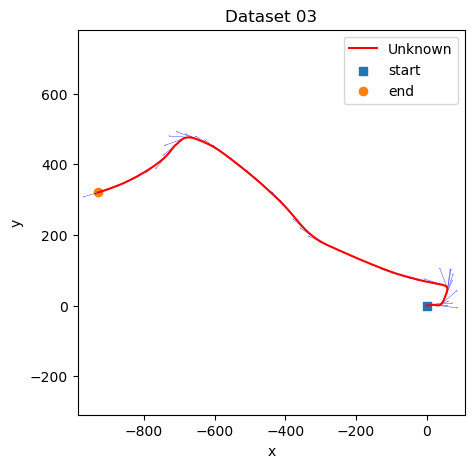

(<Figure size 500x500 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f87ff474370>)

In [45]:
visualize_trajectory_2d_own(np.transpose(meus,axes=(1,2,0)),show_ori=True,title=f'Dataset {DATASET}')

# Part 2

In [144]:
# Load the measurements
filename = f'../data/{DATASET}.npz'
t,features,linear_velocity,angular_velocity,K,b,imu_T_cam = load_data(filename)
t = np.squeeze(t,0)

features = features[:,::20,:]

INIT_T = np.eye(4)
INIT_SIGMA = np.eye(6)


In [60]:
def get_pi_input(ul,vl,ur,vr):
    x = (b*((cu-ul))/(ur-ul))
    y = (b*fsu*(cv-vl))/(fsv*(ur-ul))
    z = (b*fsu)/(ul-ur)
    return(x,y,z)
        

In [61]:
features.shape[1]

665

In [62]:
        # if(point_ind in new_points_set):
        #     meu_v[point_ind] = m_points.T[obs_ind]
        # else:
        #     meu_v[point_ind] = prev_meu_v[point_ind]


## Dead Reckon

  0%|          | 0/3025 [00:00<?, ?it/s]

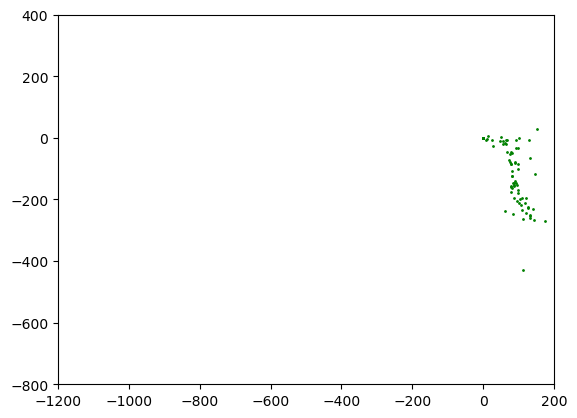

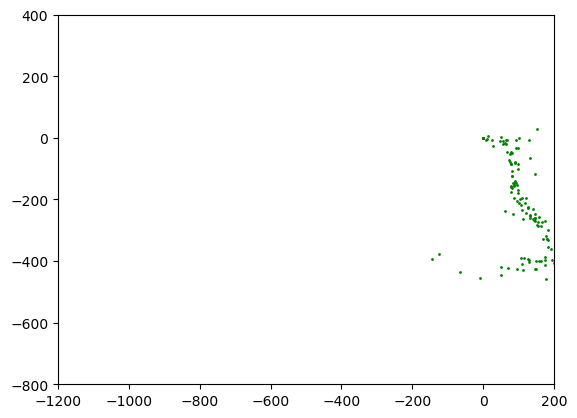

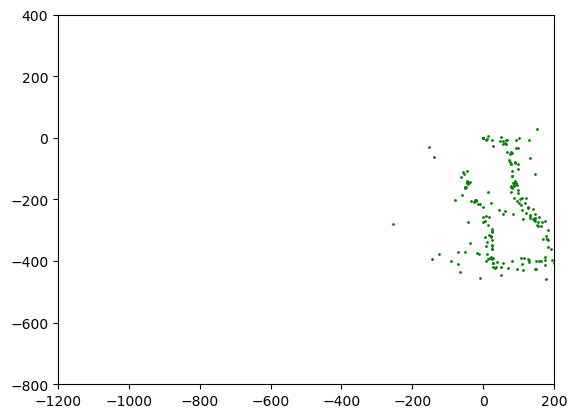

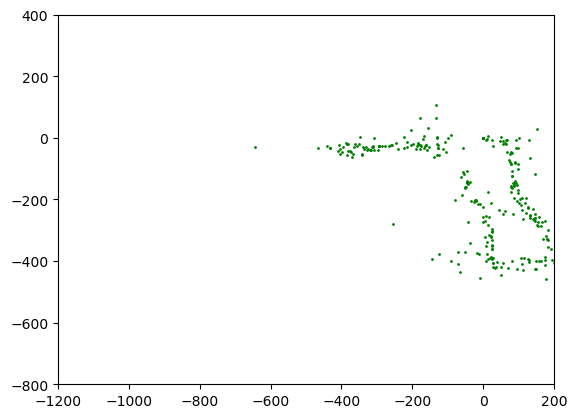

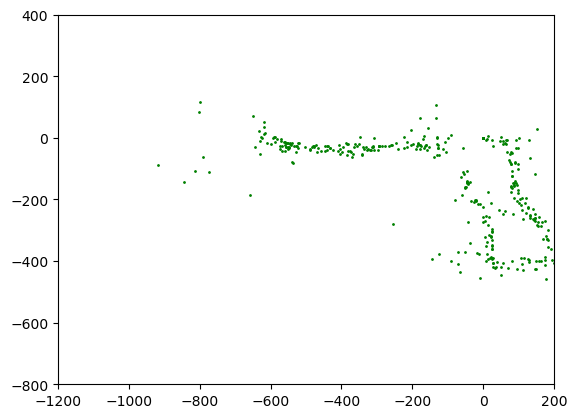

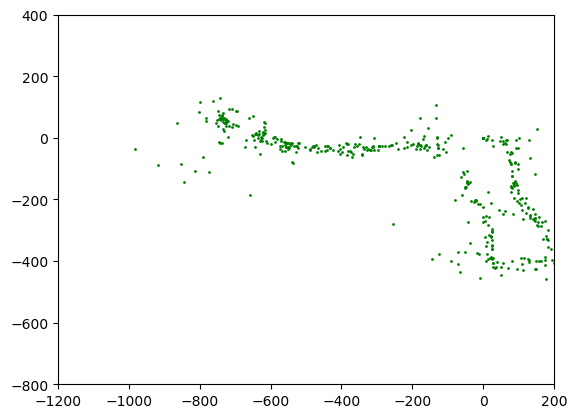

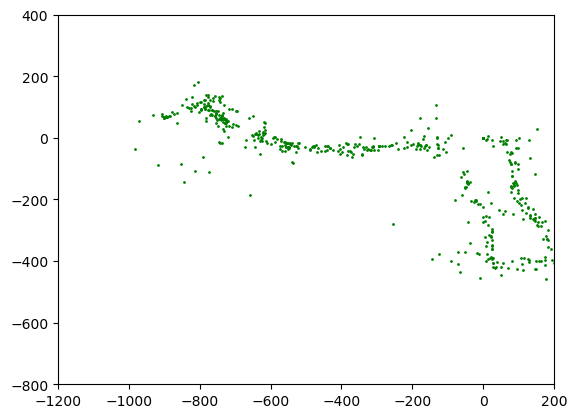

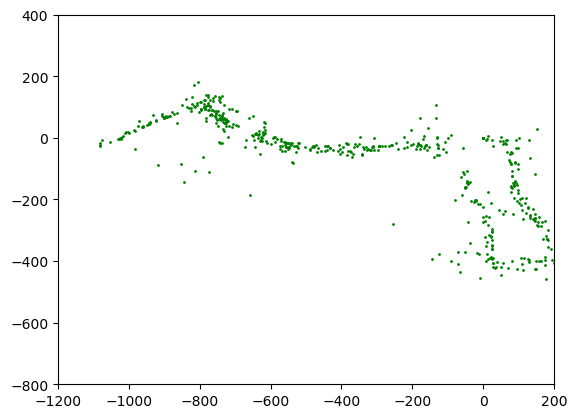

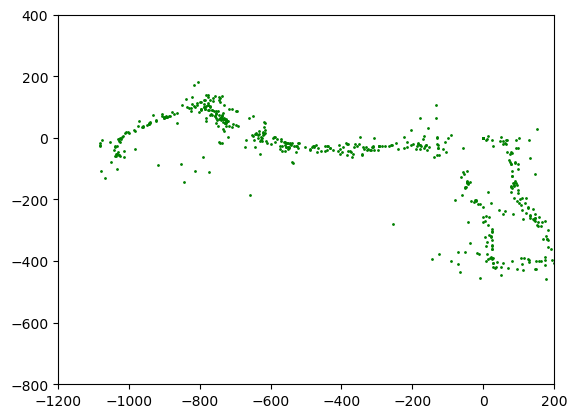

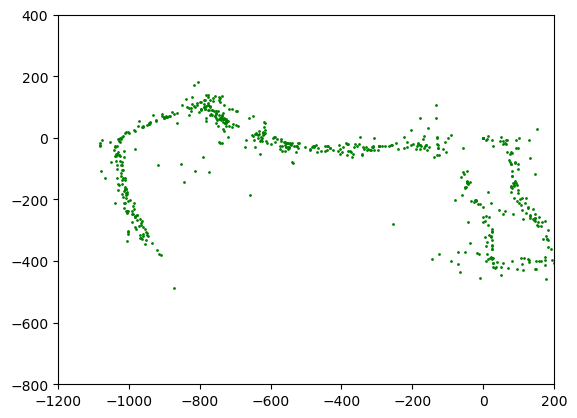

In [64]:
P = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
M = features.shape[1]
sigma = np.eye(3*M)
prev_meu_v = np.zeros((M,3))
H = np.zeros((3*M,3*M))

dts = t[1:]-t[:-1]
meu = INIT_T;
meus = [meu]
axangles = np.vstack((linear_velocity,angular_velocity)).T
adtwists = axangle2adtwist(axangles)
twists = axangle2twist(axangles)
meu_updates = twist2pose(twists[1:]*np.expand_dims(np.expand_dims(dts,-1),-1))

video_feats_world = np.zeros((M,3))

imu_T_cam_inverse = inversePose(imu_T_cam)

points_mask = np.any(features!=-1,axis=0)
ongoing_points = set()
m = np.array([0,0,0])
for i,dt in tqdm(enumerate(dts),total=dts.shape[0]):
    meu = meu @ meu_updates[i]
    meus+=[meu]

    points_ind = points_mask[...,i].nonzero()[0]
    Nt = len(points_ind)
    points_ind_set = set(points_ind)#Nt
    
    continuing_points = points_ind[np.in1d(points_ind,ongoing_points)]
    # continuing_points_set = np.in1d(points_ind,ongoing_points)
    # new_points_set = points_ind_set - continuing_points_set
    
    meu_v = np.zeros((M,3))
    feature_valid = features[:,points_ind,i]#Nt x 4 z observed
    pi_input = np.stack(get_pi_input(feature_valid[0],feature_valid[1],feature_valid[2],feature_valid[3]))
    pi_input = np.vstack([pi_input,np.expand_dims(np.ones_like(pi_input[0]),0)]) #Nt x 4
    m_points_und = meu@imu_T_cam@pi_input #Nt x 4
    m_points = P@m_points_und
    
    meu_v[points_ind] = m_points.T
    meu_v[continuing_points] = prev_meu_v[continuing_points]
    meu_v_und = np.vstack([meu_v.T,np.expand_dims(np.ones_like(meu_v.T[0]),0)])
    meu_v_und_delta = meu_v_und[...,points_ind]

    
    video_feats_world[points_ind]= (P@meu_v_und_delta).T
    prev_meu_v = meu_v
    # video_feats_world[points_ind]= m_points.T
      
    ongoing_points = points_ind
    if((i+1)%300==0):
        plt.scatter(video_feats_world[:,0],video_feats_world[:,1],s=1,c="green")
        plt.xlim(-1200,200)
        plt.ylim(-800,400)
        plt.show()
        # break
meus = np.array(meus)


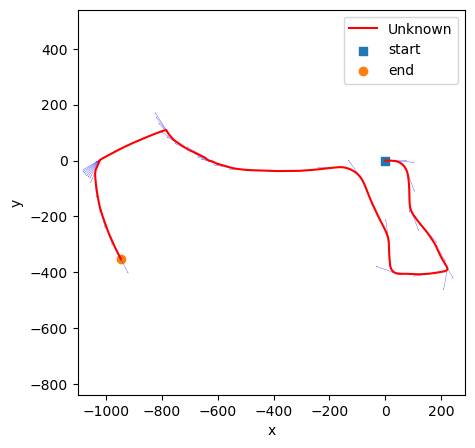

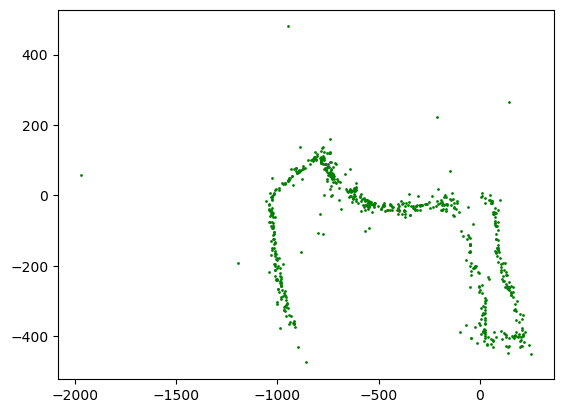

In [31]:
fig,ax = visualize_trajectory_2d(np.transpose(meus,axes=(1,2,0)),show_ori=True)
ax.clear()
plt.scatter(video_feats_world[:,0],video_feats_world[:,1],s=1,c="green")
plt.show()

## EKF

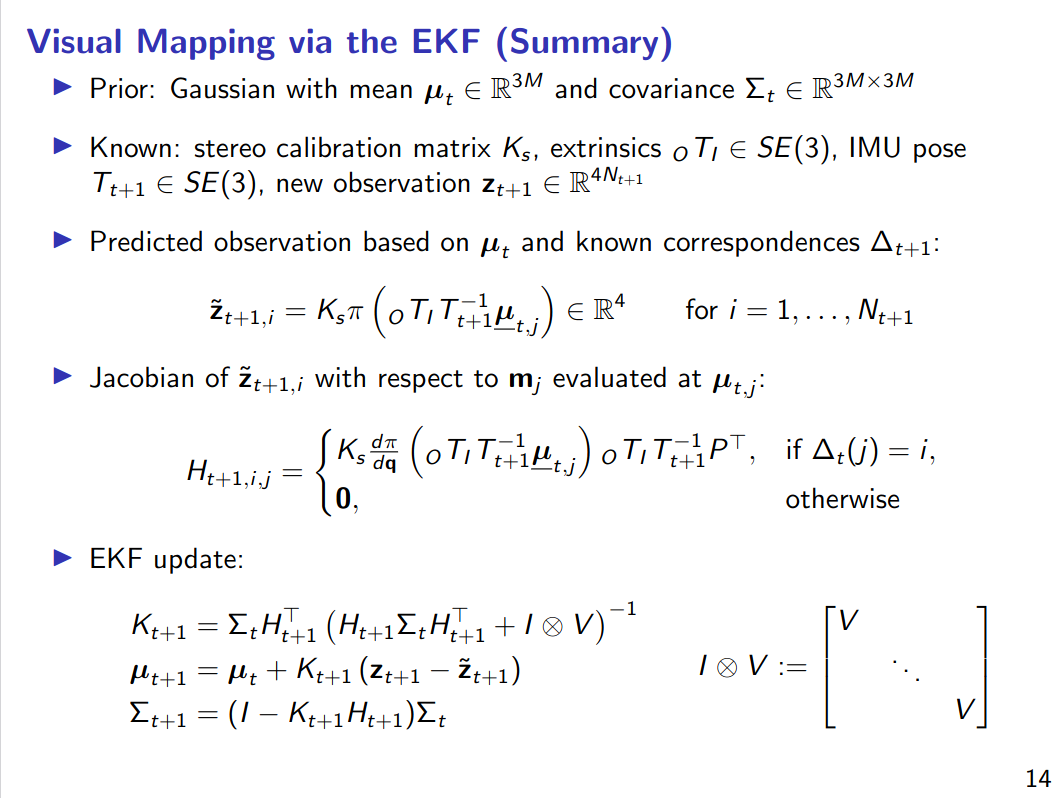

  0%|          | 0/1009 [00:00<?, ?it/s]

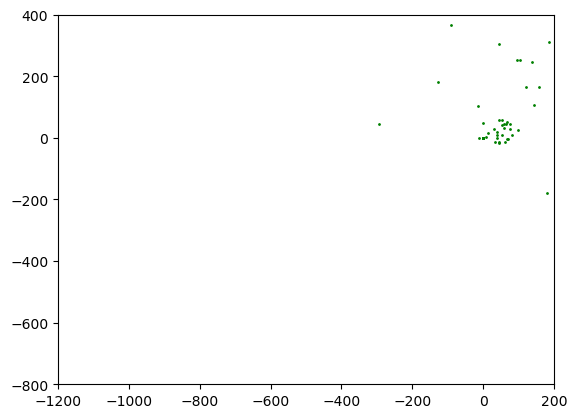

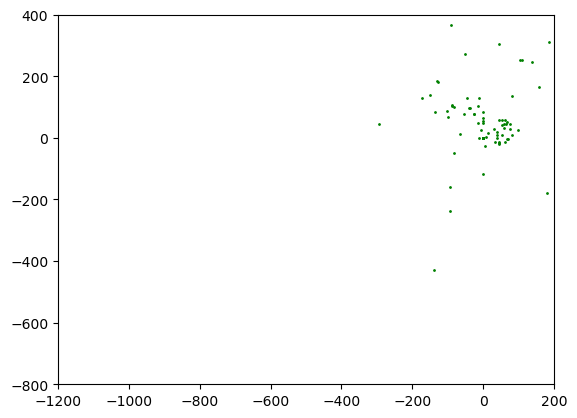

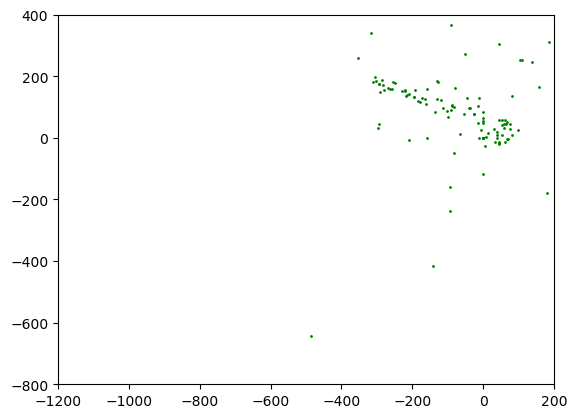

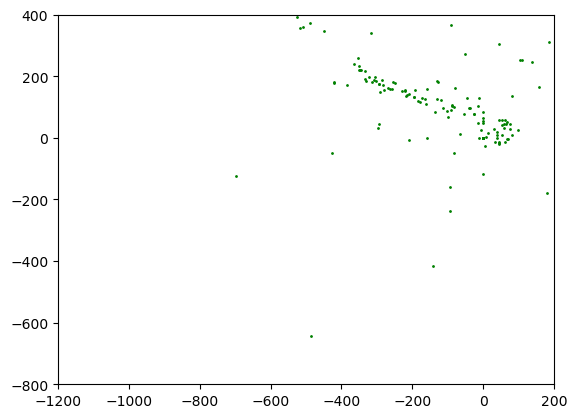

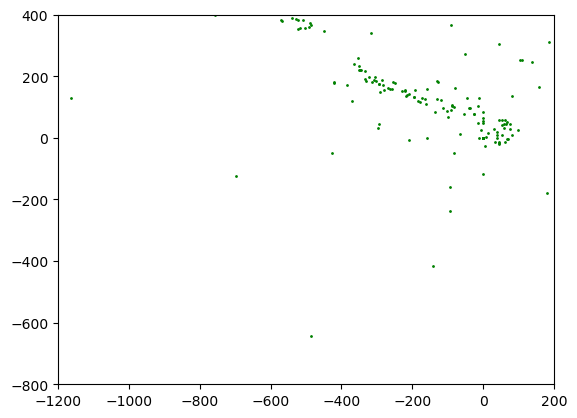

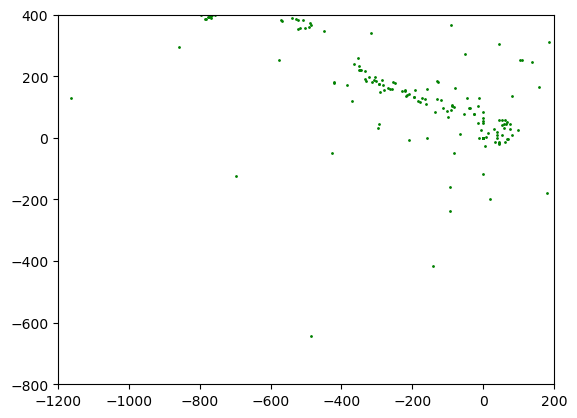

In [145]:
P = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
M = features.shape[1]
sigma = np.eye(3*M)
prev_meu_v = np.zeros((M,3))
H = np.zeros((3*M,3*M))

dts = t[1:]-t[:-1]
meu = INIT_T;
meus = [meu]
axangles = np.vstack((linear_velocity,angular_velocity)).T
adtwists = axangle2adtwist(axangles)
twists = axangle2twist(axangles)
meu_updates = twist2pose(twists[1:]*np.expand_dims(np.expand_dims(dts,-1),-1))

video_feats_world = np.zeros((M,3))

imu_T_cam_inverse = inversePose(imu_T_cam)

points_mask = np.any(features!=-1,axis=0)
ongoing_points = set()
m = np.array([0,0,0])
for i,dt in tqdm(enumerate(dts),total=dts.shape[0]):
    meu = meu @ meu_updates[i]
    meus+=[meu]

    points_ind = points_mask[...,i].nonzero()[0]
    Nt = len(points_ind)
    points_ind_set = set(points_ind)#Nt
    
    continuing_points = points_ind[np.in1d(points_ind,ongoing_points)]
    # continuing_points_set = np.in1d(points_ind,ongoing_points)
    # new_points_set = points_ind_set - continuing_points_set
    
    meu_v = np.zeros((M,3))
    feature_valid = features[:,points_ind,i]#Nt x 4 z observed
    pi_input = np.stack(get_pi_input(feature_valid[0],feature_valid[1],feature_valid[2],feature_valid[3]))
    pi_input = np.vstack([pi_input,np.expand_dims(np.ones_like(pi_input[0]),0)]) #Nt x 4
    m_points_und = meu@imu_T_cam@pi_input #Nt x 4
    m_points = P@m_points_und
    
    meu_v[points_ind] = m_points.T
    meu_v[continuing_points] = prev_meu_v[continuing_points]
    meu_v_und = np.vstack([meu_v.T,np.expand_dims(np.ones_like(meu_v.T[0]),0)])
    meu_v_und_delta = meu_v_und[...,points_ind]
    
    pi_input_with_last = (imu_T_cam_inverse@inversePose(meu)@meu_v_und_delta).T
    
    z_pred = Ks@projection(pi_input_with_last).T

    
    H = np.zeros((4*Nt,3*M))
    IV = (np.eye(4*Nt)*np.random.normal(0, 2, 4*Nt))
    H_update = (np.transpose(Ks@np.transpose(projectionJacobian(pi_input_with_last),axes=[1,2,0]),[2,0,1])@imu_T_cam_inverse@inversePose(meu)@(P.T)) #Nt x 4 x 3
    for obs_ind,point_ind in enumerate(points_ind):
        H[obs_ind * 4:(obs_ind + 1) * 4,
              point_ind * 3:(point_ind + 1) * 3] = H_update[obs_ind]
    
    sigma_into_HT = sigma@(H.T)
    K = sigma_into_HT@np.linalg.inv((H@sigma_into_HT)+IV)#3M x 4Nt
    
    prev_meu_v = meu_v+(K@(feature_valid-z_pred).T.reshape(-1)).reshape(-1,3)
    
    sigma = (np.eye(3*M)-(K@H))@sigma
    # world_frame_coords = (P@meu_v_und_delta).T
    world_frame_coords = prev_meu_v[points_ind]
    # dist_mask = np.linalg.norm(world_frame_coords-meu[:3,3],axis=1)<500
    # video_feats_world[points_ind][dist_mask]= world_frame_coords[dist_mask]
    video_feats_world[points_ind]= world_frame_coords
      
    ongoing_points = points_ind
    # if((i+1)%4==0):
    #     break
    if((i+1)%150==0):
        plt.scatter(video_feats_world[:,0],video_feats_world[:,1],s=1,c="green")
        plt.xlim(-1200,200)
        plt.ylim(-800,400)
        plt.show()
        # break
meus = np.array(meus)


In [146]:
def visualize_trajectory_2d_own_sct(pose,path_name="Unknown",show_ori=False,title="",scatterpts=None):
    '''
    function to visualize the trajectory in 2D
    Input:
        pose:   4*4*N matrix representing the camera pose, 
                where N is the number of poses, and each
                4*4 matrix is in SE(3)
    '''
    fig,ax = plt.subplots(figsize=(5,5))
    n_pose = pose.shape[2]
    ax.plot(pose[0,3,:],pose[1,3,:],'r-',label=path_name)
    ax.scatter(pose[0,3,0],pose[1,3,0],marker='s',label="start")
    ax.scatter(pose[0,3,-1],pose[1,3,-1],marker='o',label="end")
    if(not (scatterpts is None)):
        ax.scatter(scatterpts[:,0],scatterpts[:,1],s=1,c="green")
        
  
    if show_ori:
        select_ori_index = list(range(0,n_pose,max(int(n_pose/50), 1)))
        yaw_list = []
        
        for i in select_ori_index:
            _,_,yaw = mat2euler(pose[:3,:3,i])
            yaw_list.append(yaw)
    
        dx = np.cos(yaw_list)
        dy = np.sin(yaw_list)
        dx,dy = [dx,dy]/np.sqrt(dx**2+dy**2)
        ax.quiver(pose[0,3,select_ori_index],pose[1,3,select_ori_index],dx,dy,\
            color="b",units="xy",width=1)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')
    ax.set_title(title)
    ax.grid(False)
    ax.set_xbound(-10,10)
    ax.legend()
    # plt.show(block=True)

    return fig, ax



In [147]:
np.min(np.transpose(meus,axes=(1,2,0))[0,3,:])

-929.5296106882824

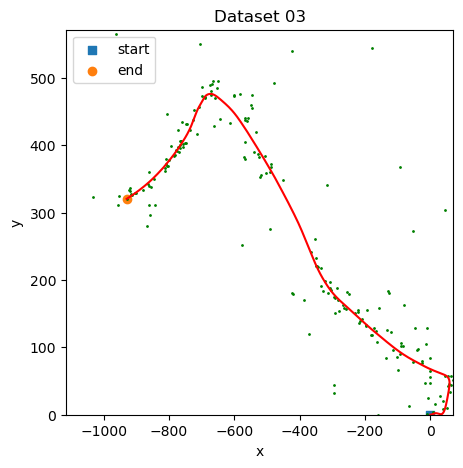

In [148]:
pose = np.transpose(meus,axes=(1,2,0))
fig,ax = plt.subplots(figsize=(5,5))
n_pose = pose.shape[2]
ax.plot(pose[0,3,:],pose[1,3,:],'r-',label="")
ax.scatter(pose[0,3,0],pose[1,3,0],marker='s',label="start")
ax.scatter(pose[0,3,-1],pose[1,3,-1],marker='o',label="end")
if(not (video_feats_world is None)):
    ax.scatter(video_feats_world[:,0],video_feats_world[:,1],s=1,c="green")
ax.set_xlim(np.min(pose[0,3,:])*1.2,np.max(pose[0,3,:])*1.2)
ax.set_ylim(np.min(pose[1,3,:])*1.2,np.max(pose[1,3,:])*1.2)

ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.axis('equal')
ax.set_title(f'Dataset {DATASET}')
ax.grid(False)
ax.legend()
plt.show(block=True)


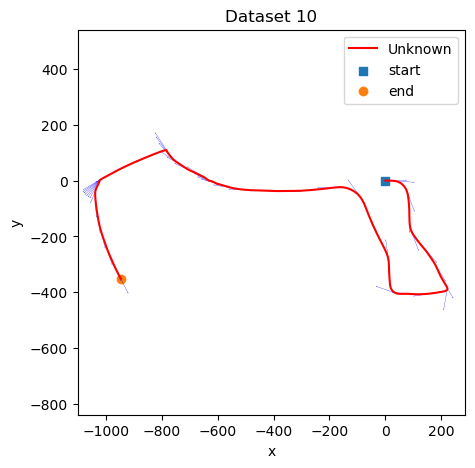

(<Figure size 500x500 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8856252550>)

In [117]:
visualize_trajectory_2d_own(np.transpose(meus,axes=(1,2,0)),show_ori=True,title=f'Dataset {DATASET}')

(<Figure size 500x500 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8856ee05b0>)

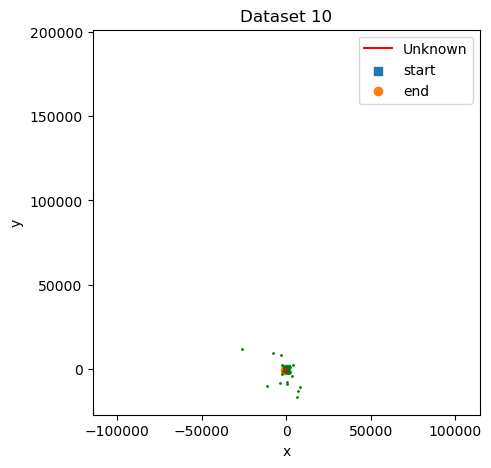

In [112]:
visualize_trajectory_2d_own_sct(np.transpose(meus,axes=(1,2,0)),show_ori=True,title=f'Dataset {DATASET}',scatterpts=video_feats_world)

# Part 3


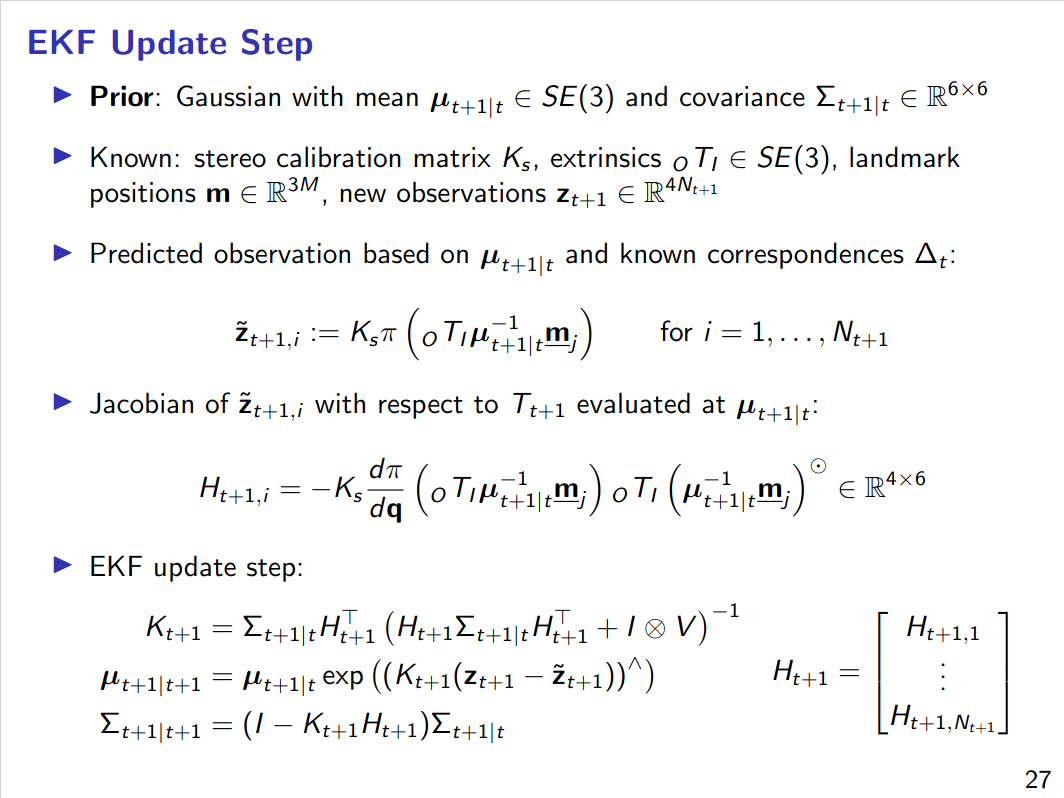

In [9]:
tes = np.array([1,2,3,1])

In [34]:
circleDotFun(tes)

array([[ 1.,  0.,  0., -0.,  3., -2.],
       [ 0.,  1.,  0., -3., -0.,  1.],
       [ 0.,  0.,  1.,  2., -1., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [33]:
def circleDotFun(s):
    conmat = np.hstack((np.eye(3),-axangle2skew(s)))
    return np.vstack((conmat,np.zeros(6)))

    

  0%|          | 0/3025 [00:00<?, ?it/s]

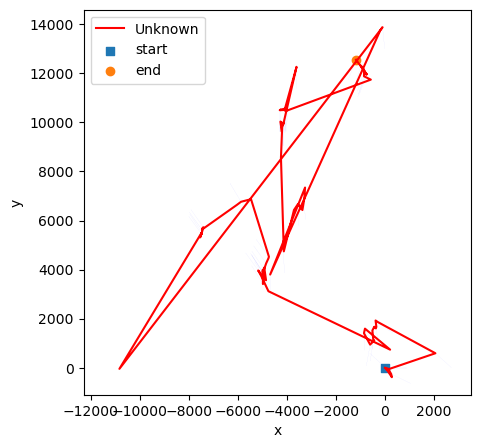

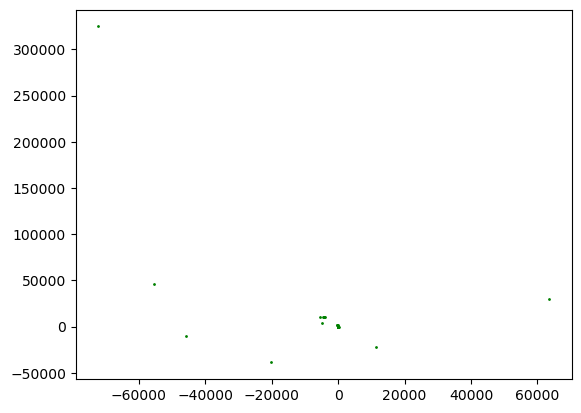

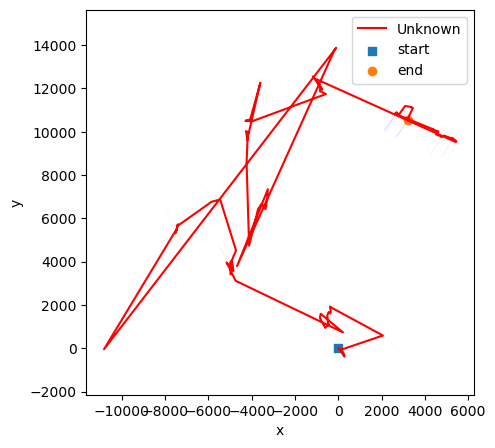

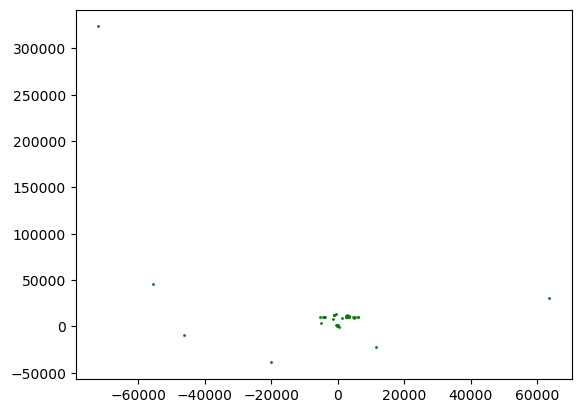

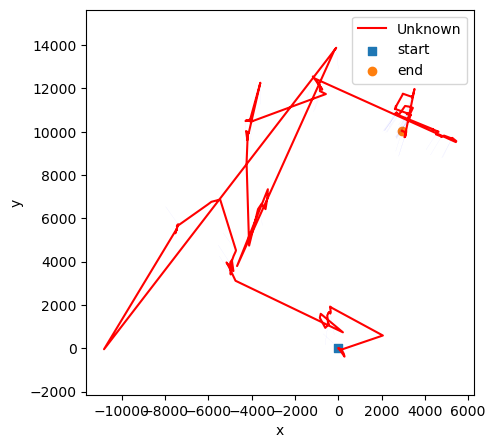

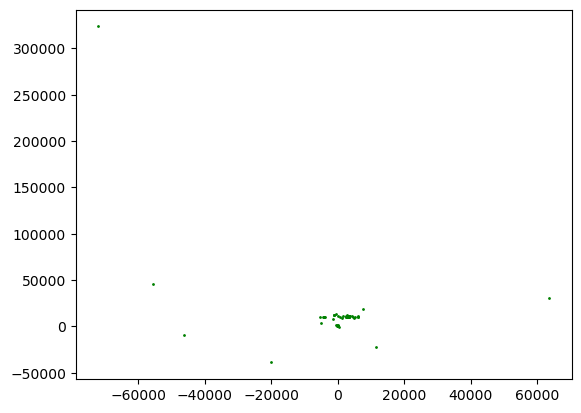

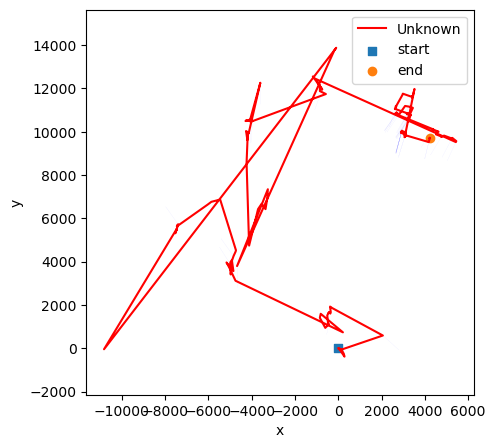

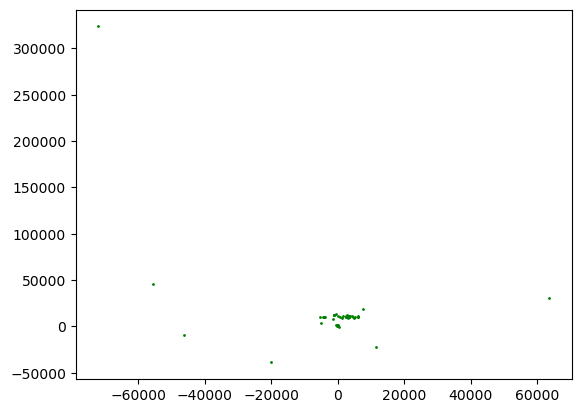

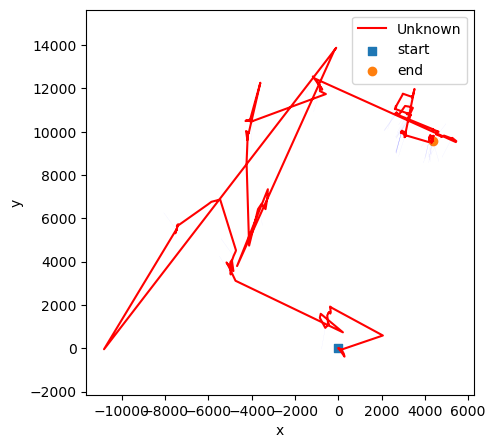

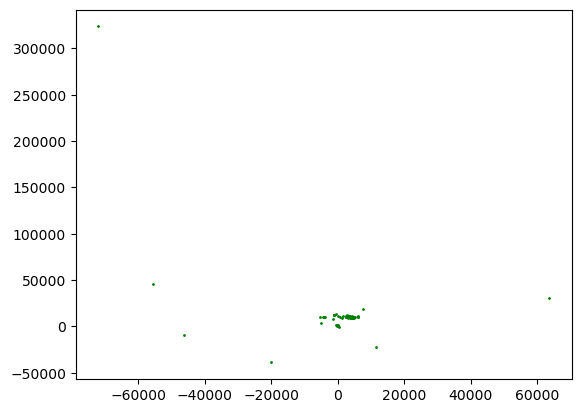

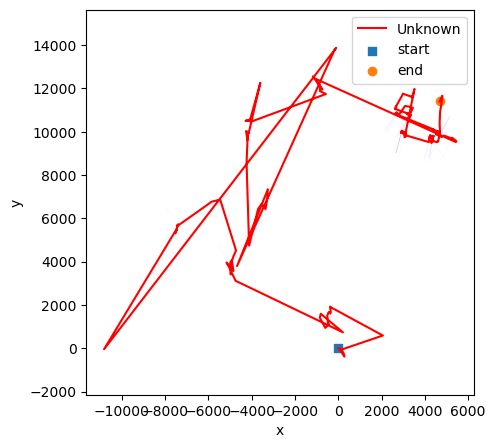

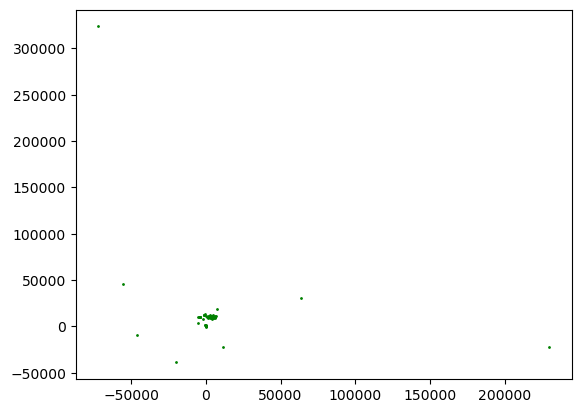

ValueError: Cannot apply_along_axis when any iteration dimensions are 0

In [192]:
P = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
M = features.shape[1]
sigma_LL = np.eye((3*M))+1e-6
sigma_RR = np.eye((6))+1e-6
sigma_LR = np.zeros((3*M,6))+1e-6
sigma_RL = np.zeros((6,3*M))+1e-6
prev_meu_v = np.zeros((M,3))
H = np.zeros((3*M,3*M))

dts = t[1:]-t[:-1]
meu = INIT_T;
meus = [meu]
axangles = np.vstack((linear_velocity,angular_velocity)).T
adtwists = axangle2adtwist(axangles)
twists = axangle2twist(axangles)
exp_ut_flower_updates = scipy.linalg.expm(-adtwists[1:]*np.expand_dims(np.expand_dims(dts,-1),-1))
W = np.eye(6)
meu_updates = twist2pose(twists[1:]*np.expand_dims(np.expand_dims(dts,-1),-1))


video_feats_world = np.zeros((M,3))

imu_T_cam_inverse = inversePose(imu_T_cam)

points_mask = np.any(features!=-1,axis=0)
ongoing_points = set()
m = np.array([0,0,0])
for i,dt in tqdm(enumerate(dts),total=dts.shape[0]):
    meu = meu @ meu_updates[i]
    # sigma_RR = exp_ut_flower_updates[i]@sigma_RR@(exp_ut_flower_updates[i].T)

    points_ind = points_mask[...,i].nonzero()[0]
    Nt = len(points_ind)
    points_ind_set = set(points_ind)#Nt
    
    continuing_points = points_ind[np.in1d(points_ind,ongoing_points)]
    # continuing_points_set = np.in1d(points_ind,ongoing_points)
    # new_points_set = points_ind_set - continuing_points_set
    
    meu_v = np.zeros((M,3))
    feature_valid = features[:,points_ind,i]#Nt x 4 z observed
    pi_input = np.stack(get_pi_input(feature_valid[0],feature_valid[1],feature_valid[2],feature_valid[3]))
    pi_input = np.vstack([pi_input,np.expand_dims(np.ones_like(pi_input[0]),0)]) #Nt x 4
    m_points_und = meu@imu_T_cam@pi_input #Nt x 4
    m_points = P@m_points_und
    
    meu_v[points_ind] = m_points.T
    meu_v[continuing_points] = prev_meu_v[continuing_points]
    meu_v_und = np.vstack([meu_v.T,np.expand_dims(np.ones_like(meu_v.T[0]),0)])
    meu_v_und_delta = meu_v_und[...,points_ind]
    
    pi_input_with_last = (imu_T_cam_inverse@inversePose(meu)@meu_v_und_delta).T
    
    z_pred = Ks@projection(pi_input_with_last).T
    
    circleDot = np.apply_along_axis(lambda x:circleDotFun(x),1,(inversePose(meu)@meu_v_und_delta)[:3].T)


    
    H = np.zeros((4*Nt,(3*M)+6))
    IV = (np.eye(4*Nt)*np.random.normal(0, 2, 4*Nt))
    H_update = (np.transpose(Ks@np.transpose(projectionJacobian(pi_input_with_last),axes=[1,2,0]),[2,0,1])@imu_T_cam_inverse@inversePose(meu)@(P.T)) #Nt x 4 x 3
    for obs_ind,point_ind in enumerate(points_ind):
        H[obs_ind * 4:(obs_ind + 1) * 4,
              point_ind * 3:(point_ind + 1) * 3] = H_update[obs_ind]
        H[obs_ind * 4:(obs_ind + 1) * 4,
              -6:] = circleDot[obs_ind]
        
    # H[obs_ind * 4:(obs_ind + 1) * 4,:] = H_mm
    # H = np.concatenate((H_update,H_mm),-1)

    sigma = np.vstack((np.hstack((sigma_LL,sigma_LR)),
                       np.hstack((sigma_RL,sigma_RR))))

    sigma_into_HT = sigma@(H.T)
    K = sigma_into_HT@np.linalg.inv((H@sigma_into_HT)+IV)#3M x 4Nt
    
    K_into_innovation = K@(feature_valid-z_pred).T.reshape(-1)
    
    prev_meu_v = meu_v+(K_into_innovation[:-6]).reshape(-1,3)
    
    sigma = (np.eye((3*M)+6)-(K@H))@sigma
    
    sigma_LL = sigma[:-6,:-6]
    sigma_RR = sigma[-6:,-6:]
    sigma_LR = sigma[:-6,-6:]
    sigma_RL = sigma[-6:,:-6]

    meu = meu @ scipy.linalg.expm(axangle2twist((K_into_innovation[-6:])))
    meus+=[meu]

    # world_frame_coords = (P@meu_v_und_delta).T
    world_frame_coords = prev_meu_v[points_ind]
    # dist_mask = np.linalg.norm(world_frame_coords-meu[:3,3],axis=1)<500
    # video_feats_world[points_ind][dist_mask]= world_frame_coords[dist_mask]
    video_feats_world[points_ind]= world_frame_coords
      
    ongoing_points = points_ind
    # if((i+1)%4==0):
    #     break
    if((i+1)%100==0):
        visualize_trajectory_2d(np.transpose(np.array(meus),axes=(1,2,0)),show_ori=True)
        plt.scatter(video_feats_world[:,0],video_feats_world[:,1],s=1,c="green")
        # plt.xlim(-1200,200)
        # plt.ylim(-800,400)
        plt.show()
        # break
meus = np.array(meus)


In [190]:
scipy.linalg.expm(axangle2twist((K_into_innovation[-6:])))

array([[ 9.98663856e-01, -7.13472017e-03, -5.11820138e-02,
         3.29348807e+02],
       [ 5.12322934e-03,  9.99213346e-01, -3.93248234e-02,
        -2.08203341e+02],
       [ 5.14223229e-02,  3.90100626e-02,  9.97914806e-01,
         2.37029043e+01],
       [ 1.54515007e-21,  3.94400673e-21,  9.09048236e-20,
         1.00000000e+00]])

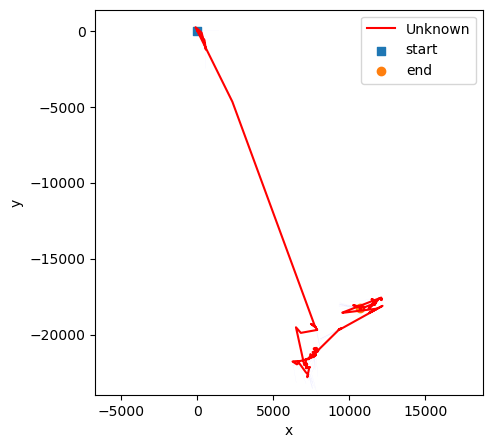

(<Figure size 500x500 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb4de5700a0>)

In [186]:
visualize_trajectory_2d(np.transpose(meus,axes=(1,2,0)),show_ori=True)

In [187]:
meus

[array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 array([[ 9.99997434e-01,  1.26658042e-03, -1.87813343e-03,
          8.47887478e-03],
        [-1.26522292e-03,  9.99998938e-01,  7.23803873e-04,
         -1.15623894e-03],
        [ 1.87904819e-03, -7.21425758e-04,  9.99997974e-01,
         -2.35901179e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 0.99176162,  0.12425197,  0.03115038, -0.01673205],
        [-0.12567913,  0.99085804,  0.04904181,  0.01055567],
        [-0.02477206, -0.05255274,  0.99831085, -0.00967115],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-2.34085854e-01,  9.56857657e-01,  1.72125642e-01,
         -7.88969351e+00],
        [-9.46583130e-01, -2.64699890e-01,  1.84158479e-01,
         -4.23292207e+00],
        [ 2.21775089e-01, -1.19822334e-01,  9.67707816e-01,
         -5.74853450e+01],
        [-4.17386620e-17, -1.3486